# Analyze cell wall deformation

In [1]:
from common.cell_wall_deformation_analysis_func import *

In [2]:
im_list = np.load('./data/image_sequence.npy')

In [3]:
analyzer = analyzer(im_list)
nuclei_list, centroids_x_list, centroids_y_list, frame_num_list, labels_list = analyzer.extract_feature()

100%|█████████████████████████████████████████| 193/193 [05:08<00:00,  1.60s/it]


In [4]:
track_result_filtered, nuclei_true, check_number = analyzer.tracker(nuclei_list, centroids_x_list, centroids_y_list, frame_num_list, labels_list)

Frame 192: 13413 trajectories present.


100%|█████████████████████████████████████████| 193/193 [01:11<00:00,  2.69it/s]


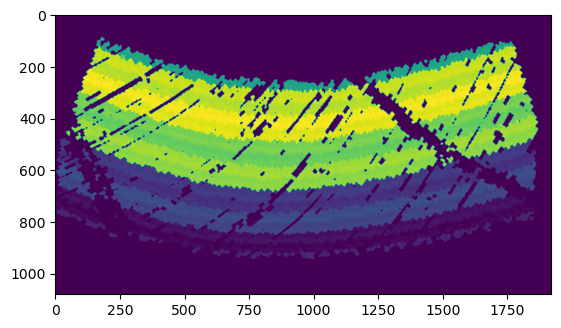

In [5]:
plt.imshow(nuclei_true[:,:,-1])

In [6]:
area_change_lists_array, ecc_change_lists_array, aspect_axis_change_lists_array, aspect_bbox_change_lists_array = analyzer.parameter_changes_cal(nuclei_true, check_number, num=5)

100%|█████████████████████████████████████████| 189/189 [01:00<00:00,  3.14it/s]


In [7]:
# np.savez_compressed('./data/deformation_analysis.npz',
#                     area_change=area_change_lists_array,
#                     ecc_change=ecc_change_lists_array,
#                     aspect_axis_change=aspect_axis_change_lists_array,
#                     aspect_bbox_change=aspect_bbox_change_lists_array,)

In [8]:
result_aspect_axis_change_rate_map = analyzer.result_visualize(nuclei_true, track_result_filtered, aspect_axis_change_lists_array)

100%|█████████████████████████████████████████| 189/189 [01:16<00:00,  2.47it/s]


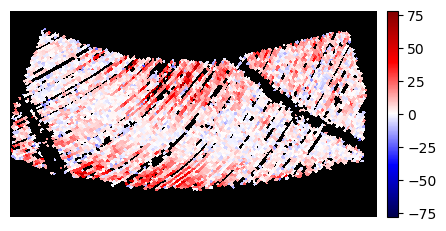

In [9]:
num = -1 # the 2D mapping before the fracture
dsiplay = np.nan_to_num(result_aspect_axis_change_rate_map, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

lim_min = np.max(np.abs(dsiplay[:,:,num]))*-1
lim_max = np.max(np.abs(dsiplay[:,:,num]))

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.axis('off')
ax.invert_yaxis()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cm = plt.cm.seismic.copy()
cm.set_bad((0, 0, 0, 1))

mesh = ax.pcolormesh(np.ma.array(dsiplay[:,:,num], mask=nuclei_true[:,:,num]==0), cmap = cm)
mesh.set_clim(lim_min,lim_max)

fig.colorbar(mesh,cax=cax)

In [10]:
# np.savez_compressed('./data/map.npz',
#                     nuclei = nuclei_true[:,:,4:],
#                     aspect_axis_change = result_aspect_axis_change_rate_map)